#### Importing all libraries required

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.color as color
import cv2
from skimage import io
from scipy import signal

#### Read Image - The image is that of a circle

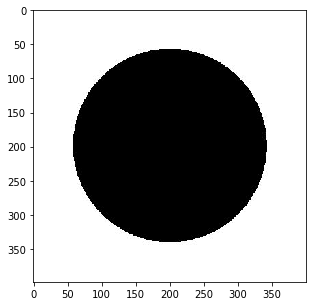

In [3]:
image = io.imread('blackCircle.jpg')
image = color.rgb2gray(image)
fig = plt.figure(figsize = (5,5))
plt.imshow(image, cmap = 'gray')

#### Applying Gaussian Blur to the image to get better edges

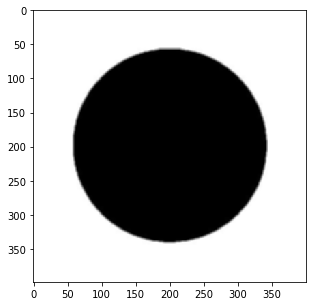

In [4]:
image = cv2.GaussianBlur(image, (5,5), 2, cv2.BORDER_DEFAULT)
fig = plt.figure(figsize = (5,5))
plt.imshow(image, cmap = 'gray')

#### Initializing the snake with 15 points around the circle

In [5]:
numberOfPoints = 15
theta = np.linspace(0, 2 * np.pi, numberOfPoints)
sin = image.shape[1]//2 + 180 * np.sin(theta)
cos = image.shape[0]//1.92 - 10 + 180 * np.cos(theta)
snakePlot = np.array([sin, cos], dtype = 'int').T

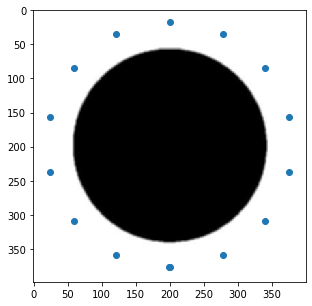

In [6]:
fig = plt.figure(figsize = (5,5))
plt.imshow(image, cmap = 'gray')
plt.scatter(snakePlot[:, 0], snakePlot[:, 1])
plt.show()

#### Function to find the Image Gradients for External Energy

In [7]:
def gaussianDerivativeFilter(axis, size, sigma):
    
    mu = size // 2
    kernel = np.zeros((size, size))
    if axis == 'x':
        for y in range(size):
            for x in range(size):
                kernel[x, y] = ((-(x - mu)) / (2 * np.pi * sigma ** 4)) * np.exp(-(((x - mu) ** 2 + (y - mu) ** 2) / (2 * sigma ** 2)))
    
    else:
        for x in range(size):
            for y in range(size):
                kernel[x, y] = ((-(x - mu)) / (2 * np.pi * sigma ** 4)) * np.exp(-(((x - mu) ** 2 + (y - mu) ** 2) / (2 * sigma ** 2)))
    
    return kernel                                                   

In [8]:
xFilter = gaussianDerivativeFilter(0, 5, 1)
yFilter = gaussianDerivativeFilter(1, 5, 1)
xImage = signal.convolve2d(image, xFilter, mode = 'same')
yImage = signal.convolve2d(image, yFilter, mode = 'same')

#### Function to calculate Total Energy (External Energy and Internal Energy (Continuity Energy and Smoothness Energy)

In [9]:
def totalEnergy(alpha, beta, gamma, index, snake, avgDistance):
    
    currentPoint = snake[index, :]
    [x, y] = snake[index, :]
    i, j = 0, 0
    minimum = 1e9
    x, y = int(x), int(y)
    
    for i in range(-1, 2):
        for j in range(-1, 2):
            
            newPoint = np.array([y + j, x + i])
            
            if (y + j < image.shape[0] and x + i < image.shape[1]):
                
                externalEnergy = (-(xImage[y + j, x + i] ** 2 + yImage[y + j, x + i] ** 2) + (xImage[y, x] ** 2 + yImage[y, x] ** 2))
                
                nextPoint = snake[(index + 1) % numberOfPoints, :]
                previousPoint = snake[(index - 1) % numberOfPoints, :]
                
                continuityEnergy = ((np.linalg.norm(newPoint - nextPoint) - avgDistance) ** 2 - (np.linalg.norm(currentPoint - nextPoint) - avgDistance) ** 2)
                smoothnessEnergy = (np.linalg.norm((2 * newPoint) - nextPoint - previousPoint)) ** 2 - (np.linalg.norm((2 * currentPoint) - nextPoint - previousPoint)) ** 2
                
                if (alpha * continuityEnergy + beta * smoothnessEnergy + gamma * externalEnergy < minimum):
                    
                    minimum = alpha * continuityEnergy + beta * smoothnessEnergy + gamma * externalEnergy
                    a, b = i, j
                    
    snake[index, :] = [x + a, y + b]
    return snake

#### Function to calculate the average distance between contour points of the snake

In [10]:
def averageDistance(snake):
    
    sum = 0
    
    for index in range(snake.shape[0]):
        
        currentPoint = snake[index, :]
        nextPoint = snake[(index + 1) % numberOfPoints, :]
        sum += np.linalg.norm(currentPoint - nextPoint)
        
    return sum/snake.shape[0]

#### Iterating the snake using a greedy approach

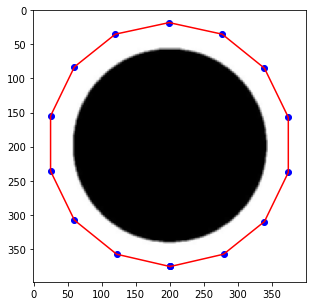

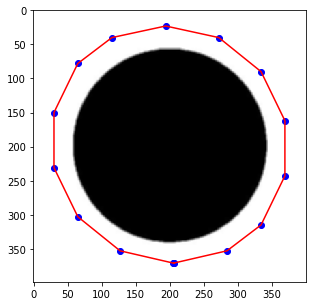

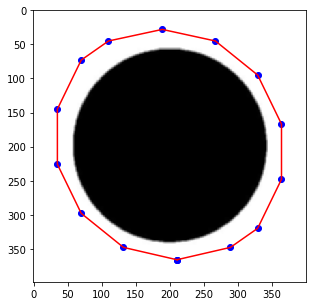

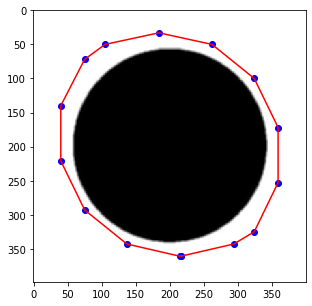

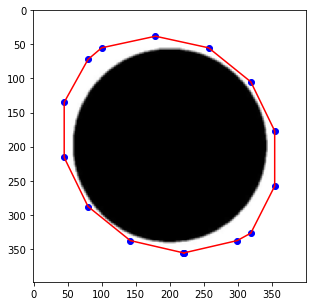

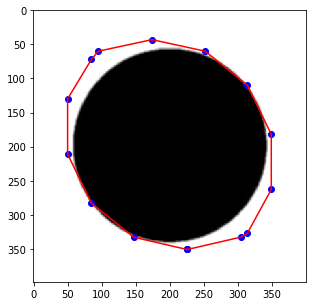

In [11]:
for j in range(30):
    for i in range(numberOfPoints):
        
        snakePlot = totalEnergy(1, 4.5, 3, i, snakePlot ,averageDistance(snakePlot))
    
    if(j%5==0):
        
        plot = np.zeros((snakePlot.shape[0] + 1, 2))
        plot[:snakePlot.shape[0], :] = snakePlot
        plot[snakePlot.shape[0], :] = snakePlot[0,:]
        
        fig = plt.figure(figsize = (5, 5))
        plt.imshow(image, cmap = 'gray')
        plt.plot(plot[:, 0], plot[:, 1], color = 'red')
        plt.scatter(plot[:, 0], plot[:, 1], color = 'blue')